# Building Damage Assessment - Deep Neural Network

This notebook classify the building damage with simple neural network

## Set up and Load Data

### Google Drive & Path

In [0]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd "/content/drive/My Drive/FinalProj"
%ls "./Data/FireDataset/train"

### Prepare Packages

In [0]:
!pip install rasterio

     |████████████████████████████████| 18.2MB 1.4MB/s 


In [0]:
!pip install geopandas

     |████████████████████████████████| 931kB 2.6MB/s 
     |████████████████████████████████| 14.7MB 209kB/s 
     |████████████████████████████████| 10.9MB 30.1MB/s 


In [0]:
!pip install imagecodecs
!pip install tifffile
#need to upgrade to read compressed tiff in Colab
!pip install --upgrade scikit-image

     |████████████████████████████████| 17.9MB 1.5MB/s 
     |████████████████████████████████| 12.4MB 246kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [0]:
from skimage import io
import imagecodecs
import os, fnmatch,tifffile
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)
#check gpu
tf.config.list_physical_devices('GPU')



2.2.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
# retrieve file path + names based on extension
def lstFiles(rootPath, ext):
    file_list = []
    root = rootPath
    for path, subdirs, files in os.walk(root):
        for names in files: 
            if names.endswith(ext) and not names.startswith("._"):
                file_list.append(path  +"/" + names)
    return(file_list)


# get merged all test/train dataset
merged_path = "./Data/FireDataset/merged_shp"
merged_files = lstFiles(merged_path, '.shp')
gdf = gpd.read_file(merged_files[0])
santaRosa = gdf.query("location_n == 'santa-rosa-wildfire'")
ID_list=santaRosa.ID.unique()

In [0]:
#get files by match pattern
def find(pattern, path):
    '''
    #find names of files that match the pattern
    args:
    pattern: string to be matched
    path: path of files
    '''
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [0]:
folder='./NAIP_img_new/'
#the number of features
n_feature=44
data=np.empty(shape=(0,n_feature),dtype='float')
#counter=0
#combine all pre post images together
#for index in ID_list:
#test on a subset
for index in ID_list[:10]:
    #files=find('*'+index+'*.tif', folder) # data not returned in desired order for each index
    #pre
    img=io.imread(folder+'pre_'+index+'.tif')
    gt=io.imread(folder+'pre_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data=np.concatenate((data,img),axis=0)
    #post
    img=io.imread(folder+'post_'+index+'.tif')
    gt=io.imread(folder+'post_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data=np.concatenate((data,img),axis=0)
    #counter+=1
    #if counter%50==0:
        #print(index+'concatenated!')



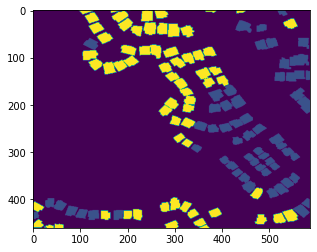

In [0]:
plt.imshow(gt)

## 5-layer Neural Network

In [0]:
#check device
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11022465583480019790
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15196149567237051079
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10543914979562640176
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11279859045653327752
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
# 
# try if reduce the size of non-building class would help
#import random
#Y=data[:,-1]
#ind_nonbuilding=np.where(Y==0)[0].tolist()
#ind_nonbuilding=random.sample(ind_nonbuilding, len(ind_nonbuilding)//7)
#ind_building=np.where(Y!=0)[0].tolist()
#ind_select=ind_nonbuilding+ind_building

In [0]:
#data_subset=data[ind_select]

In [0]:
#get ground truth label and group all types of damage as one type
Y=data[:,-1]
Y[Y>=2]=2
Y=Y.astype('int')

### Convert y variable to dummy variable

In [0]:
# encode class values as integers
# from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(Y)

Using TensorFlow backend.


In [0]:
#tf.debugging.set_log_device_placement(True)
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((data[:,:-1],dummy_y))
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(batch_size)

### Define a 5-layer network for multi-class prediction

In [0]:
def model_settings(unit1,unit2,unit3,unit4,unit5):
    'define a 5-layer model and generate 3 categories: non-building, no-damage, destroyed'
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(unit1,activation="relu"),
        tf.keras.layers.Dense(unit2,activation='relu'),
        tf.keras.layers.Dense(unit3,activation='selu'),
        tf.keras.layers.Dense(unit4,activation='relu'),
        tf.keras.layers.Dense(unit5,activation='sigmoid'),
        #tf.keras.layers.Dense(3,activation='softmax')
        tf.keras.layers.Dense(3)
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#def model_settings(unit1,unit2):
#    'define a 2-layer model and generate 3 categories: non-building, no-damage, destroyed'
#    model = tf.keras.Sequential([
#        tf.keras.layers.Dense(unit1,activation="relu"),
#        tf.keras.layers.Dense(unit2,activation='sigmoid'),
#        tf.keras.layers.Dense(3)
#    ])
#    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model


In [0]:
#tune parameter with a batch to save time
tune_X,tune_y=next(iter(train_dataset))

In [0]:
unit1s=[1024,128,64,32,64,32,15]
unit2s=[512,64,32,16,32,16,10]
unit3s=[32,32,64,32,16,10,5]
unit4s=[10,16,32,32,10,5,3]
unit5s=[5,8,16,16,5,3,3]
#change epoch in here for tuning
num_epochs = 50


#for unit1 in unit1s:
#    for unit2 in unit2s:
for unit1, unit2, unit3, unit4,unit5 in zip(unit1s,unit2s,unit3s, unit4s,unit5s):
    model=model_settings(unit1,unit2,unit3,unit4,unit5)
    print('___')
    print('layer1: ',unit1,'; layer2: ',unit2,'; layer3: ',unit3,'; layer4: ',unit4,'; layer5: ',unit5)
    #use a validation split of 0.2 in here
    history = model.fit(tune_X, tune_y, epochs=num_epochs, validation_split = 0.2)

___
layer1:  1024 ; layer2:  512 ; layer3:  32 ; layer4:  10 ; layer5:  5
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 0s 24ms/step - loss: 0.5835 - accuracy: 1.0000 - val_loss: 0.5488 - val_accuracy: 1.0000
Epoch 2/50
13/13 [==============================] - 0s 9ms/step - loss: 0.5459 - accuracy: 1.0000 - val_loss: 0.5127 - val_accuracy: 1.0000
Epoch 3/50
13/13 [==============================] - 0s 8ms/step - loss: 0.5107 - accuracy: 1.0000 - val_loss: 0.4791 - val_accuracy: 1.0000
Epoch 4/50
13

In [0]:
num_epochs = 201
#As show above, based on 20% validation, the best model is with 1024,512,32,10, 5 units for the five hidden layers
model_select=model_settings(1024,512,32,10,5)
#model_select=model_settings(15,3)

history = model_select.fit(train_dataset, epochs=num_epochs)

Epoch 1/201

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

2172/2172 [==============================] - 15s 7ms/step - loss: 0.7539 - accuracy: 0.7168
Epoch 2/201
2172/2172 [==============================] - 15s 7ms/step - loss: 0.7634 - accuracy: 0.7047
Epoch 3/201
2172/2172 [==============================] - 14s 7ms/step - loss: 0.7551 - accuracy: 0.7063
Epoch 4/201
2172/2172 [==============================] - 14s 7ms/step - loss: 0.7532 - accuracy: 0.7064
Epoch 5/201
2172/2172 [==============================] - 14s 7ms/step - loss: 0.7527 - accur

## Test Results

In [0]:
# get some test data
folder='./NAIP_img_new/'
#the number of features
n_feature=44
data_test=np.empty(shape=(0,n_feature),dtype='float')
shapes=[]
#counter=0
#combine all pre post images together
#for index in ID_list:
#test on a subset
for index in ID_list[10:15]:
    #files=find('*'+index+'*.tif', folder) # data not returned in desired order for each index
    #pre
    img=io.imread(folder+'pre_'+index+'.tif')
    gt=io.imread(folder+'pre_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    shapes.append(img.shape)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data_test=np.concatenate((data_test,img),axis=0)
    #post
    img=io.imread(folder+'post_'+index+'.tif')
    gt=io.imread(folder+'post_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    shapes.append(img.shape)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data_test=np.concatenate((data_test,img),axis=0)
    #if counter%50==0:
        #print(index+'concatenated!')



In [0]:
Y_test=data_test[:,-1]
Y_test[Y_test>=2]=2
Y_test=Y_test.astype('int')
dummy_y_test = np_utils.to_categorical(Y_test)

In [0]:
#tf.debugging.set_log_device_placement(True)
batch_size = 512
#get the test data
test_dataset = tf.data.Dataset.from_tensor_slices((data_test[:,:-1],dummy_y_test))
test_dataset = test_dataset.batch(batch_size)

In [0]:
#evaluate the model based on the test data
loss, accuracy = model_select.evaluate(test_dataset)

2031/2031 [==============================] - 8s 4ms/step - loss: 8.5979 - accuracy: 0.9092


In [0]:
#test
test_predictions=model_select.predict(test_dataset)

In [0]:
prediction_class= np.argmax(test_predictions, axis = 1)

In [0]:
print('The accuracy is: ',sum(prediction_class==Y_test)/len(Y_test))

The accuracy is:  0.909159112944182


In [0]:
from sklearn import metrics

In [0]:
print('The accuracy and weighted f1 score for xgboost with best parameters are: ',metrics.accuracy_score(Y_test,prediction_class),' and ',metrics.f1_score(Y_test,prediction_class,average='weighted'))

The accuracy and weighted f1 score for xgboost with best parameters are:  0.909159112944182  and  0.8658998477866714


In [0]:
print('The cohen Kappa is: ',metrics.cohen_kappa_score(Y_test,prediction_class),' and ',metrics.balanced_accuracy_score(Y_test,prediction_class))

The cohen Kappa is:  0.0  and  0.3333333333333333


In [0]:
cm=metrics.confusion_matrix(Y_test,prediction_class, labels=[0,1,2])
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[945220      0      0]
 [ 87461      0      0]
 [  6983      0      0]]


### Prediction and Visualization

In [0]:
def pred_visual(folder,index,state,features):
    '''
    This function takes one image, calculate the testing score on the image and visualize predictions
    folder: the folder (relative) to access the image
    index: string, image id: 00000XXX
    state: string, pre or post
    features: list of string, names of features
    '''
    img=io.imread(folder+state+'_'+index+'.tif')
    gt=io.imread(folder+state+'_'+index+'gt.tif')
    gt[gt>=2]=2
    shapes=img.shape
    #add ground truth as the last band
    img_data=np.concatenate((img,gt[:,:,None]),axis=2)
    img_data=np.reshape(img_data,(shapes[0]*shapes[1],(shapes[2]+1)))

    #organize dataframe
    img_data=pd.DataFrame(img_data,columns=features)
    X_te=img_data.iloc[:,:-1]
    y_te=img_data['y']
    #group y from 5 classes to 3 classes: 0: non building 1: undestroyed and 2: destroyed (remove minor and major imacts due to the limited samples)
    y_te[y_te>=2]=2
    y_te=y_te.astype('int')
    #pred_y=gbc.predict(X_te)
    test_predictions=model_select.predict(X_te)
    pred_y= np.argmax(test_predictions, axis = 1)
    print('The accuracy and Kappa for this image are: ',metrics.accuracy_score(y_te,pred_y),' and ',metrics.cohen_kappa_score(y_te,pred_y))
    pred_image=np.reshape(pred_y,(shapes[0],shapes[1]))

    #show images
    _, axs = plt.subplots(1, 3, figsize=(11, 12))
    axs = axs.flatten()
    #for img, ax in zip([np.uint8(img[:,:,:3]),gt,pred_image], axs):
    for img, ax in zip([img[:,:,:3]/255,gt,pred_image],axs):
        ax.grid(False)
        ax.imshow(img,vmin=0, vmax=2,cmap='brg')
    plt.show() 

In [0]:
features=['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'R_contrast', 'N_contrast', 'R_corr', 'G_corr', 'B_corr', 'N_corr', 'R_var', 'N_var', 'R_idm', 'G_idm', 'B_idm', 'N_idm', 'R_diss', 'N_diss', 'R_shade', 'G_shade', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'KMeans', 'KMeans_Seg', 'SNIC', 'LVQ']
features.append('y')

Pre fire prediction:
The accuracy and Kappa for this image are:  0.01315946289528047  and  0.0


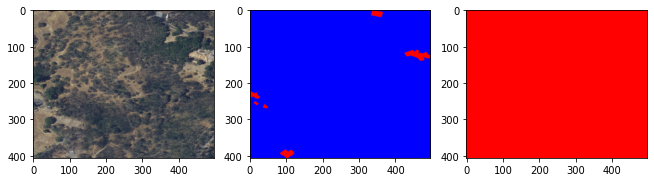

In [0]:
folder=folder='./NAIP_img_new/'
index='00000081'
state='pre'
print('Pre fire prediction:')
pred_visual(folder,index,state,features=features)

Post fire prediction:
The accuracy and Kappa for this image are:  0.9868405371047195  and  0.0


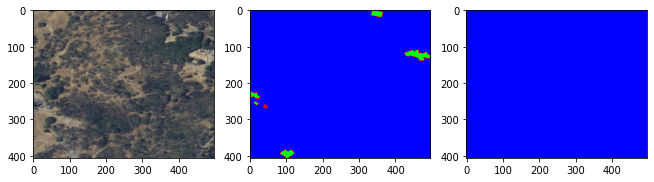

In [0]:
folder=folder='./NAIP_img_new/'
index='00000081'
state='post'
print('Post fire prediction:')
pred_visual(folder,index,state,features=features)

__Results Interpretation__
The 5-layer deep neural networks doesn't seem to work well in both identifying building footprints and classifying damage type, especially when comparing with XGBoost (see XGBoost notebook). The high accuracy of 90.9% is only an actual ratio of sample distribution in the testing datasets (90% of the pixels in the testing set were non-building). The network will label all pixels as one type. Although the imbanlanced training sample size might be the problem, a follow-up model trained on the same training data with 6/7 of the non-building pixels randomly being dropped (so the ratio between non-building and building approximately equals to 1:1) also didn't show any improvement on this issue (however, all pixels were labeled as no-damage this time).

### Supplementary: Results from 2-layer neural network
Maps shown below are results from a 2-layer neural network. Although the accuracy is relatively lower (~0.8), the visualization of the results actually make more sense. There might be some error detection, but the 2-layer network is able to detect some pixels within the building boundary.

In [0]:
# show the first id image
index=ID_list[10]
img_pre=io.imread(folder+'pre_'+index+'.tif')
gt_pre=io.imread(folder+'pre_'+index+'gt.tif')
img_post=io.imread(folder+'post_'+index+'.tif')
gt_post=io.imread(folder+'post_'+index+'gt.tif')

In [0]:
#for pre and post of the first image id
pred_pre=prediction_class[:shapes[0][0]*shapes[0][1]]
pred_post=prediction_class[shapes[0][0]*shapes[0][1]:shapes[0][0]*shapes[0][1]+shapes[1][0]*shapes[1][1]]

In [0]:
pred_pre=np.reshape(pred_pre,(shapes[0][0],shapes[0][1]))
pred_post=np.reshape(pred_post,(shapes[1][0],shapes[1][1]))

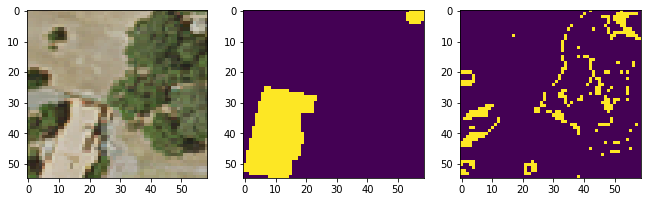

In [0]:
_, axs = plt.subplots(1, 3, figsize=(11, 12))
axs = axs.flatten()
for img, ax in zip([np.uint8(img_pre[:,:,:3]),gt_pre,pred_pre], axs):
    ax.imshow(img)
plt.show()

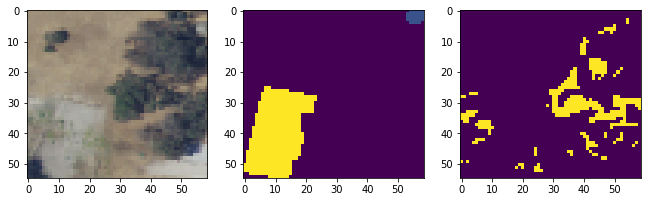

In [0]:
_, axs = plt.subplots(1, 3, figsize=(11, 12))
axs = axs.flatten()
for img, ax in zip([np.uint8(img_post[:,:,:3]),gt_post,pred_post], axs):
    ax.imshow(img)
plt.show()

In [0]:
# show the first id image
index=ID_list[13]
img_pre=io.imread(folder+'pre_'+index+'.tif')
gt_pre=io.imread(folder+'pre_'+index+'gt.tif')
img_post=io.imread(folder+'post_'+index+'.tif')
gt_post=io.imread(folder+'post_'+index+'gt.tif')

In [0]:
#for pre and post of the first image id
pred_pre=prediction_class[462966:462966+shapes[6][0]*shapes[6][1]]
pred_post=prediction_class[462966+shapes[6][0]*shapes[6][1]:462966+shapes[6][0]*shapes[6][1]+shapes[7][0]*shapes[7][1]]

In [0]:
pred_pre=np.reshape(pred_pre,(shapes[6][0],shapes[6][1]))
pred_post=np.reshape(pred_post,(shapes[7][0],shapes[7][1]))

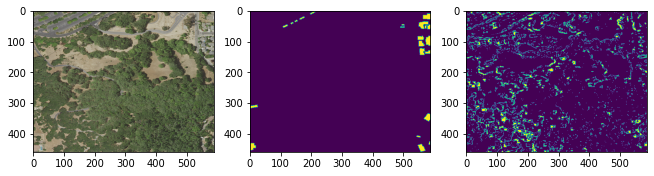

In [0]:
_, axs = plt.subplots(1, 3, figsize=(11, 12))
axs = axs.flatten()
for img, ax in zip([np.uint8(img_pre[:,:,:3]),gt_pre,pred_pre], axs):
    ax.imshow(img)
plt.show()

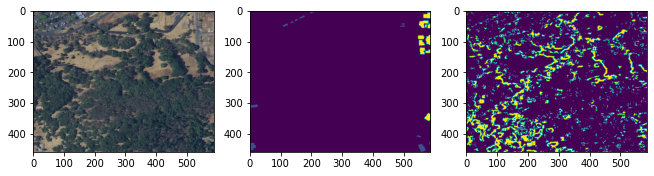

In [0]:
_, axs = plt.subplots(1, 3, figsize=(11, 12))
axs = axs.flatten()
for img, ax in zip([np.uint8(img_post[:,:,:3]),gt_post,pred_post], axs):
    ax.imshow(img)
plt.show()